In [61]:
# Import necessary libraries
import pandas as pd
import os
import sys
import matplotlib.pyplot as plt
import seaborn as sns

# Add the parent directory to the path to import the calculate_accuracy module
sys.path.append('/home/kalkiek/projects/instruction-retrieval/')
from src.evaluation.calculate_accuracy import calculate_accuracy, calculate_topic_accuracies

# Define the results directory
results_dir = "/shared/3/projects/instruction-retrieval/results/variant_results"

variant_files = [f for f in os.listdir(results_dir) if f.endswith('.tsv') and "_raw" not in f]
print(f"Found {len(variant_files)} variant result files")


Found 10 variant result files


In [62]:
variant_results = {}
variant_dfs = {}

for file in variant_files:
    variant_name = file.replace('.tsv', '')
    file_path = os.path.join(results_dir, file)
    
    print(f"Processing {variant_name}...")
    
    # Read the TSV file
    df = pd.read_csv(file_path, sep='\t')
    
    # Check if the file has the necessary columns
    required_columns = ['answer', 'raw_response']
    if not all(col in df.columns for col in required_columns):
        print(f"  Skipping {variant_name} - missing required columns")
        continue
    
    variant_dfs[variant_name] = df
    
    # Calculate accuracy metrics
    has_extracted = 'extracted_answer' in df.columns
    extracted_col = 'extracted_answer' if has_extracted else None
    
    # Calculate accuracy metrics
    accuracy_results, df_with_metrics = calculate_accuracy(
        df, 
        answer_col='answer', 
        raw_response_col='raw_response', 
        extracted_answer_col=extracted_col
    )
    
    # Store results
    variant_results[variant_name] = accuracy_results
    variant_dfs[variant_name] = df_with_metrics
    
    # Print summary
    print(f"  Raw response accuracy: {accuracy_results['answer_in_raw']:.4f}")
    if has_extracted:
        print(f"  Extracted answer accuracy: {accuracy_results['answer_in_extracted']:.4f}")
        print(f"  Exact match accuracy: {accuracy_results['exact_match']:.4f}")
    print()


Processing few_show_cot_Llama_3.2_1B_Instruct...
  Raw response accuracy: 0.2333
  Extracted answer accuracy: 0.0667
  Exact match accuracy: 0.0000

Processing instructions_baseline_Llama_3.2_1B_Instruct...
  Raw response accuracy: 0.2000
  Extracted answer accuracy: 0.1667
  Exact match accuracy: 0.1000

Processing few_show_cot_Llama_3.2_3B_Instruct...
  Raw response accuracy: 0.5000
  Extracted answer accuracy: 0.2333
  Exact match accuracy: 0.2000

Processing instructions_baseline_Llama_3.2_3B_Instruct...
  Raw response accuracy: 0.3333
  Extracted answer accuracy: 0.1667
  Exact match accuracy: 0.1333

Processing instructions_baseline_few_show_cot_Llama_3.2_3B_Instruct...
  Raw response accuracy: 0.4333
  Extracted answer accuracy: 0.2000
  Exact match accuracy: 0.1667

Processing instructions_concise_Llama_3.2_3B_Instruct...
  Raw response accuracy: 0.3333
  Extracted answer accuracy: 0.2000
  Exact match accuracy: 0.1667

Processing instructions_concise_few_show_cot_Llama_3.2_3B_

In [63]:
summary_data = []
for variant, metrics in variant_results.items():
    row = {'variant': variant}
    row.update(metrics)
    summary_data.append(row)

summary_df = pd.DataFrame(summary_data)

print("Summary of variant accuracies:")
if 'answer_in_extracted' in summary_df.columns:
    display(summary_df.sort_values('answer_in_extracted', ascending=False))
else:
    display(summary_df.sort_values('answer_in_raw', ascending=False))

Summary of variant accuracies:


,variant,answer_in_raw,exact_match,answer_in_extracted
2,few_show_cot_Llama_3.2_3B_Instruct,0.500000,0.200000,0.233333
6,instructions_concise_few_show_cot_Llama_3.2_3B...,0.466667,0.233333,0.233333
5,instructions_concise_Llama_3.2_3B_Instruct,0.333333,0.166667,0.200000
4,instructions_baseline_few_show_cot_Llama_3.2_3...,0.433333,0.166667,0.200000
3,instructions_baseline_Llama_3.2_3B_Instruct,0.333333,0.133333,0.166667
7,instructions_student_Llama_3.2_3B_Instruct,0.300000,0.133333,0.166667
1,instructions_baseline_Llama_3.2_1B_Instruct,0.200000,0.100000,0.166667
8,instructions_student_few_show_cot_Llama_3.2_3B...,0.366667,0.133333,0.133333
0,few_show_cot_Llama_3.2_1B_Instruct,0.233333,0.000000,0.066667


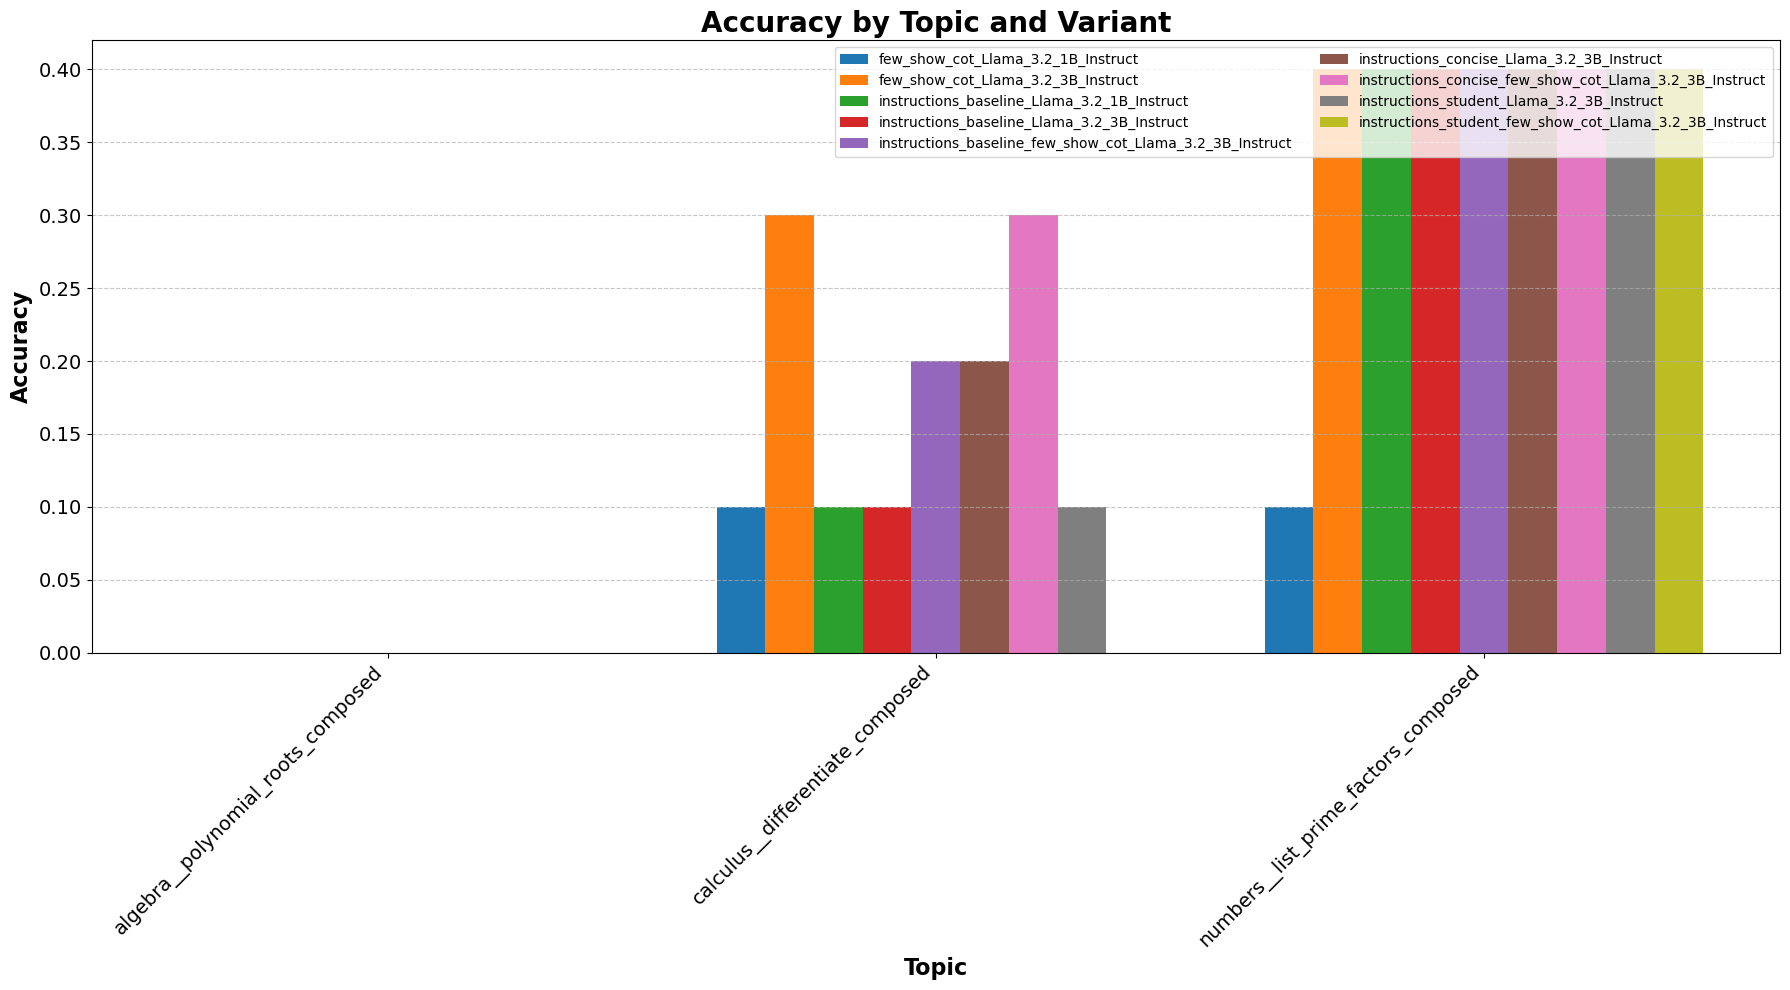

In [66]:
topic_accuracies = {}
for variant, df in variant_dfs.items():
    topic_accuracies[variant] = calculate_topic_accuracies(df)

plot_data = []
for variant, topic_acc in topic_accuracies.items():
    for topic, row in topic_acc.iterrows():
        accuracy = row['answer_in_extracted'] if 'answer_in_extracted' in row else row['answer_in_raw']
        plot_data.append({
            'Topic': topic,
            'Variant': variant,
            'Accuracy': accuracy
        })

plot_df = pd.DataFrame(plot_data)

# Get unique topics and variants
topics = sorted(plot_df['Topic'].unique())
variants = sorted(plot_df['Variant'].unique())

# Create a figure with appropriate size
plt.figure(figsize=(18, 10))

# Set the positions for the bars
bar_width = 0.8 / len(variants)
topic_positions = range(len(topics))

# Create the grouped bar chart
for i, variant in enumerate(variants):
    variant_data = plot_df[plot_df['Variant'] == variant]
    positions = [pos + (i - len(variants)/2 + 0.5) * bar_width for pos in topic_positions]
    
    # Get accuracy values for this variant across all topics
    accuracies = []
    for topic in topics:
        topic_variant_data = variant_data[variant_data['Topic'] == topic]
        if not topic_variant_data.empty:
            accuracies.append(topic_variant_data['Accuracy'].values[0])
        else:
            accuracies.append(0)
    
    plt.bar(positions, accuracies, width=bar_width, label=variant)

# Customize the plot
plt.xlabel('Topic', fontsize=16, fontweight='bold')
plt.ylabel('Accuracy', fontsize=16, fontweight='bold')
plt.title('Accuracy by Topic and Variant', fontsize=20, fontweight='bold')
plt.xticks(topic_positions, topics, fontsize=14, rotation=45, ha='right')
plt.yticks(fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add legend with smaller font to fit all variants
plt.legend(fontsize=10, loc='upper right', bbox_to_anchor=(1, 1), ncol=2)

# Adjust layout
plt.tight_layout()
plt.show()

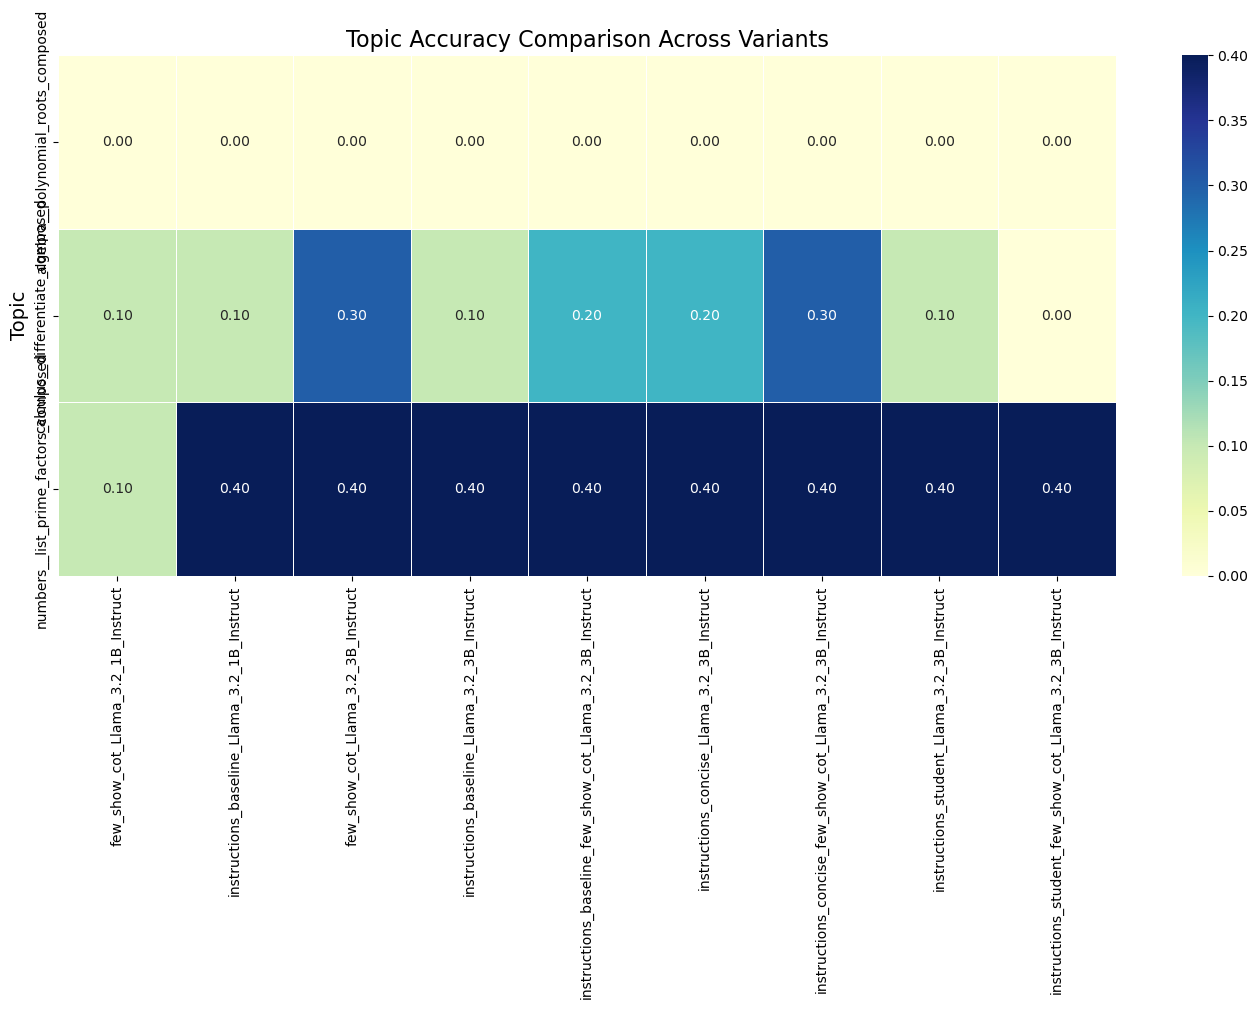

In [65]:
topic_comparison = pd.DataFrame()

for variant, topic_acc in topic_accuracies.items():
    if 'answer_in_extracted' in topic_acc.columns:
        topic_comparison[variant] = topic_acc['answer_in_extracted']
    else:
        topic_comparison[variant] = topic_acc['answer_in_raw']

# Plot the heatmap if we have data
if not topic_comparison.empty:
    plt.figure(figsize=(14, 10))
    sns.heatmap(topic_comparison, annot=True, cmap='YlGnBu', fmt='.2f', linewidths=.5)
    plt.title('Topic Accuracy Comparison Across Variants', fontsize=16)
    plt.ylabel('Topic', fontsize=14)
    plt.tight_layout()
    plt.show()
else:
    print("No topic comparison data available for visualization")

In [44]:
# Define functions to check if answer appears in different columns
def answer_in_raw(row):
    if pd.isna(row['raw_response']) or pd.isna(row['answer']):
        return False
    
    # Convert answer to string and clean it for comparison
    answer_str = str(row['answer'])
    raw_str = str(row['raw_response'])
    
    # Simple check if answer appears in raw response
    return answer_str in raw_str

def answer_in_extracted(row):
    if pd.isna(row['extracted_answer']) or pd.isna(row['answer']):
        return False
    
    # Convert to strings for comparison
    extracted = str(row['extracted_answer'])
    answer = str(row['answer'])
    
    # Check if answer appears in extracted_answer
    return answer in extracted

# Apply accuracy checks to both dataframes
baseline_df['answer_in_raw'] = baseline_df.apply(answer_in_raw, axis=1)
instruct_df['answer_in_raw'] = instruct_df.apply(answer_in_raw, axis=1)
# instruct_df['answer_in_extracted'] = instruct_df.apply(answer_in_extracted, axis=1)

# Calculate overall accuracies
print("Overall Accuracies:")
print(f"Baseline (answer in raw): {baseline_df['answer_in_raw'].mean():.4f}")
print(f"Instruct (answer in raw): {instruct_df['answer_in_raw'].mean():.4f}")
print(f"Instruct (answer in extracted): {instruct_df['answer_in_extracted'].mean():.4f}")

# Group by topic and calculate accuracies for baseline
baseline_topic_accuracies = baseline_df.groupby('topic').agg({
    'answer_in_raw': 'mean',
    'topic': 'count'
}).rename(columns={'topic': 'count'})

# Group by topic and calculate accuracies for instruct
instruct_topic_accuracies = instruct_df.groupby('topic').agg({
    'answer_in_raw': 'mean',
    'answer_in_extracted': 'mean',
    'topic': 'count'
}).rename(columns={'topic': 'count'})

# Merge the two dataframes to compare side by side
merged_accuracies = pd.merge(
    baseline_topic_accuracies, 
    instruct_topic_accuracies,
    left_index=True, 
    right_index=True, 
    suffixes=('_baseline', '_instruct')
)

# Sort by the difference between instruct extracted and baseline raw
merged_accuracies['improvement'] = merged_accuracies['answer_in_extracted'] - merged_accuracies['answer_in_raw_baseline']
merged_accuracies_sorted = merged_accuracies.sort_values('improvement', ascending=False)

Overall Accuracies:
Baseline (answer in raw): 0.4033
Instruct (answer in raw): 0.4633


KeyError: 'answer_in_extracted'

<Figure size 1800x1200 with 0 Axes>

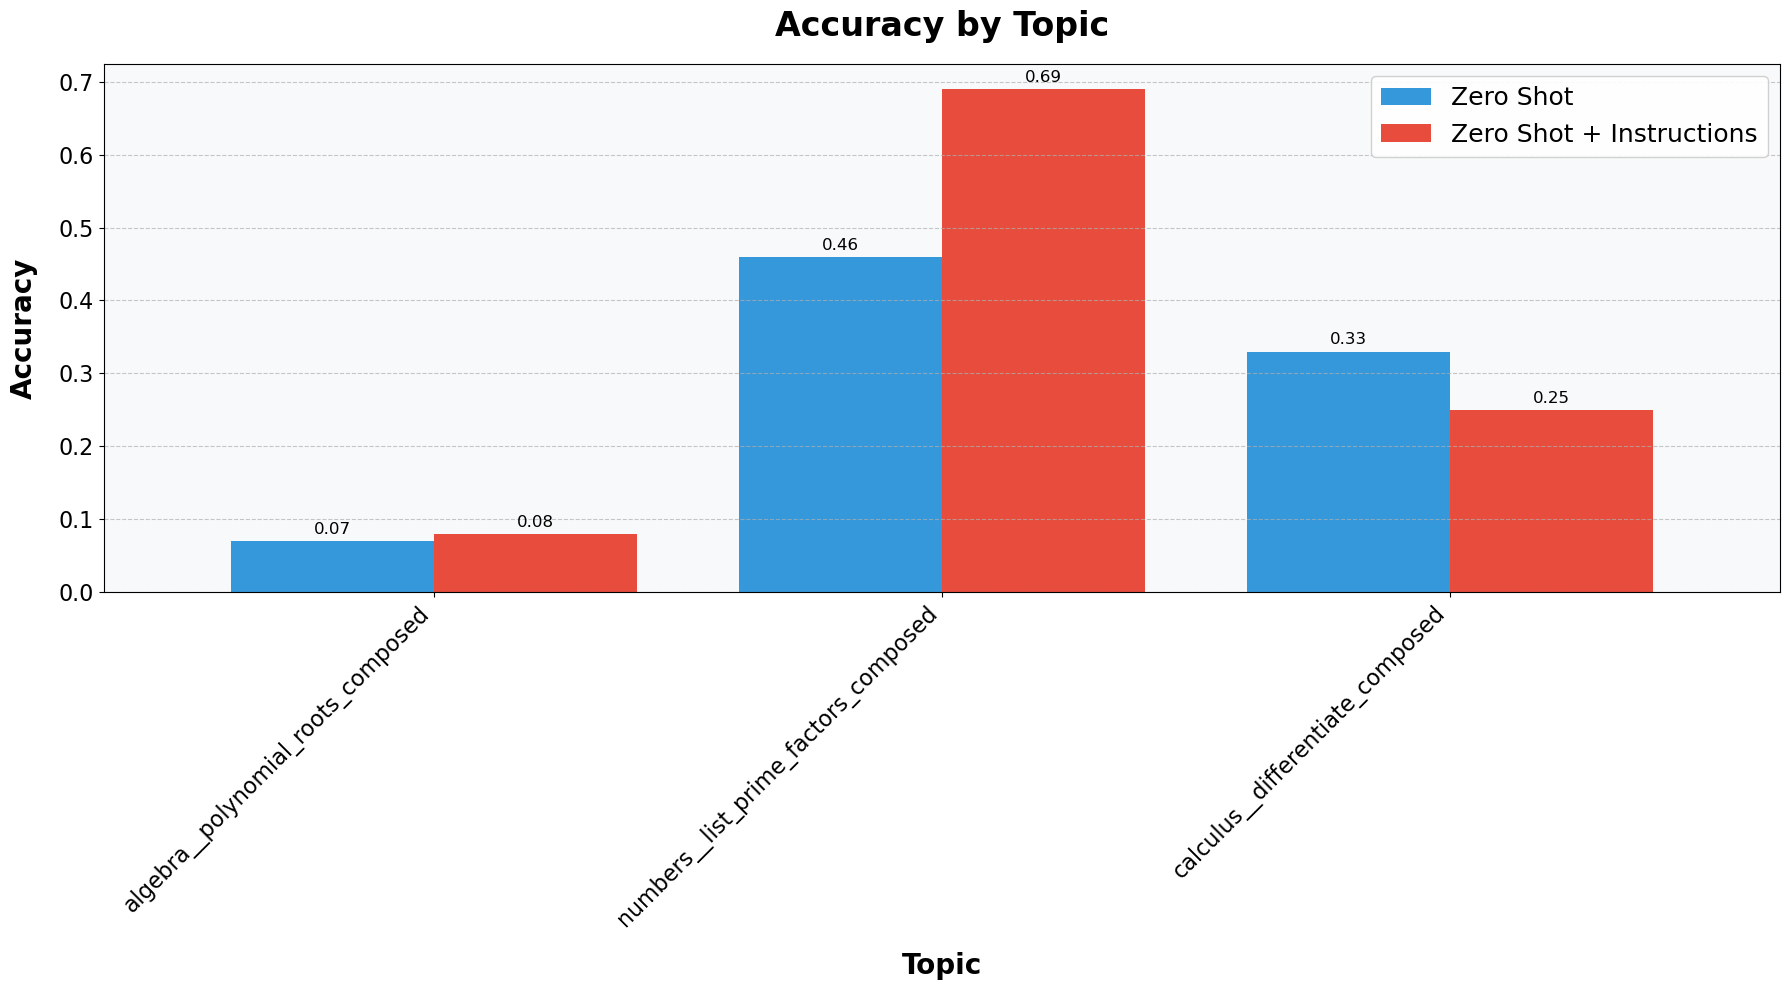

In [48]:
# ... existing code ...

# Create a more polished bar chart with larger font sizes
plt.figure(figsize=(18, 12))
ax = merged_accuracies_sorted[['answer_in_raw_baseline', 
                          'answer_in_raw_instruct']].plot(
    kind='bar', 
    figsize=(18, 10),
    width=0.8,
    color=['#3498db', '#e74c3c']  # Blue and red colors
)

# Increase font sizes
plt.title('Accuracy by Topic', fontsize=24, fontweight='bold', pad=20)
plt.ylabel('Accuracy', fontsize=20, fontweight='bold', labelpad=15)
plt.xlabel('Topic', fontsize=20, fontweight='bold', labelpad=15)
plt.xticks(rotation=45, ha='right', fontsize=16)
plt.yticks(fontsize=16)

# Customize legend
plt.legend(['Zero Shot', 'Zero Shot + Instructions'], 
           fontsize=18, 
           frameon=True, 
           framealpha=0.9,
           loc='upper right')

# Add grid for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Adjust layout
plt.tight_layout()

# Optional: Add a light background color
ax.set_facecolor('#f8f9fa')

# Optional: Add value labels on top of bars
for container in ax.containers:
    ax.bar_label(container, fmt='%.2f', fontsize=12, padding=3)

plt.show()
# ... existing code ...